# 1. Import

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize

# 2. Prepare Data

In [2]:
# 디렉토리 위치 정의
train_dir = '/opt/ml/input/data/train'
test_dir = '/opt/ml/input/data/eval'

#train dataset 정보
train_info = pd.read_csv(os.path.join(train_dir, 'train.csv'))

#train dataset file names
train_dir_names = [name for name in glob(f'{train_dir}/images/*')]
train_images = [glob(f'{d}/*') for d in train_dir_names]

train_file_names = np.array(train_images).reshape(1, -1).flatten()
train_file_names = [name.split('images/')[-1] for name in np.sort(train_file_names)]

# test dataset file names
image_dir = os.path.join(test_dir, 'images')
image_paths = [os.path.join(image_dir, img_id) for img_id in train_info.id]

test_file_names = [item for item in glob(f'{test_dir}/images/*')]

In [3]:
# 성별, 연령 별 데이터 개수
groupby_gender = train_info.groupby('gender').count().drop(['age','race','path'], axis=1).rename(columns={'id':'count'})
groupby_age = train_info.groupby('age').count().drop(['gender','race','path'], axis=1).rename(columns={'id':'count'})

In [ ]:
# file_name에서 feature 추출
df = pd.DataFrame(train_file_names, columns=['file_name'])
# df['id'], df['race'], df['mask'], df['gender'], df['age'], df['class'] = pd.nan
df['class'] = -1

for idx in df.index:
    df.loc[idx, 'id'] = df.loc[idx, 'file_name'].split('/')[0].split('_')[0]
    df.loc[idx, 'race'] = df.loc[idx, 'file_name'].split('/')[0].split('_')[2]
    df.loc[idx, 'mask'] = df.loc[idx, 'file_name'].split('/')[-1].split('.')[0]
    df.loc[idx, 'gender'] = df.loc[idx, 'file_name'].split('/')[0].split('_')[1]
    df.loc[idx, 'age'] = df.loc[idx, 'file_name'].split('/')[0].split('_')[3]

df

In [ ]:
# datatype 변경
df['age']=df.astype({'age':'int'})['age']
df['class']=df.astype({'age':'int'})['class']

In [ ]:
# 해당하는 bool 변수 정의 후 labelling

mask_bool = [((df['mask']!='normal') & (df['mask']!='incorrect_mask')), (df['mask']=='incorrect_mask'), (df['mask']=='normal')]
gender_bool = [(df['gender']=='male'), (df['gender']=='female')]
age_bool = [(df['age']<30),  ((df['age']>=30) & (df['age']<60)), (df['age']>=60)]

class_num = 0

for mask in mask_bool:
    for gender in gender_bool:
        for age in age_bool:
            get_index = df[mask & gender & age].index
            df.loc[get_index, 'class'] = class_num
            class_num += 1
df

In [ ]:
# csv 파일로 저장
df.to_csv("labelled_data.csv", index=False)

---

# 3. Data Description

## Gender

In [ ]:
groupby_gender

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.bar(groupby_gender.index, groupby_gender['count'],
       color=['tomato', 'royalblue'],
       width=0.5)
ax.margins(0.2, 0.2)

for idx, val in groupby_gender['count'].iteritems():
    ax.text(x=idx, 
            y=val+5, 
            s=val, 
            va='bottom', 
            ha='center',
            fontsize=14, 
            fontweight='semibold')
    
plt.xticks(fontsize =14, fontweight='semibold')

plt.show()

In [ ]:
intervals = list(range(10, 61, 10))
labels = [f'{str(x)}~{str(x+9)}' if x!=60 else '60~' for x in intervals]
intervals.append(70)

In [ ]:
train_info["age_group"] = pd.cut(train_info["age"], bins=intervals, right=False, labels=labels)
train_info[train_info["age"]>=50]

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(13, 7))

color=['tomato', 'royalblue']
x = np.arange(len(labels))
width=0.3

group = train_info.groupby('gender')['age_group'].value_counts().sort_index()

for idx, g in enumerate(["female", "male"]):
    ax.bar(x+(-1+2*idx)*width/2, group[g], 
       width=width, label=g, color=color[idx])

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()    
    
plt.show()

In [ ]:
intervals = list(range(0, 90, 30))
labels = [f'{str(x)}~{str(x+29)}' if x!=60 else '60~' for x in intervals]
intervals.append(70)
labels

In [ ]:
train_info["age_group"] = pd.cut(train_info["age"], bins=intervals, right=False, labels=labels)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(13, 7))

color=['tomato', 'royalblue']
x = np.arange(len(labels))
width=0.3

group = train_info.groupby('gender')['age_group'].value_counts().sort_index()

for idx, g in enumerate(["female", "male"]):
    ax.bar(x+(-1+2*idx)*width/2, group[g], 
       width=width, label=g, color=color[idx])

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()    
    
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7), dpi=300)
ax.plot(groupby_age.index, groupby_age['count'])
plt.show()

In [ ]:
groupby_age.sort_values(by=['count'], ascending=False)[:10]

In [ ]:
groupby_class = df.groupby('class')['gender'].value_counts().sort_index()
groupby_class

* Asian 데이터 밖에 없는데, 다른 인종의 데이터가 필요할까?
* 남성보다 여성의 데이터 수가 많다.
* 18\~20세 50\~60대의 데이터가 많다.
* 클래스 간 데이터 개수의 격차가 많이 난다.

### 확인해볼 것

* 어떤 속성이 있고 속성 간 관계?
* 사진 단위로 데이터 정리 O
* incorrect_mask, mask1, mask2, mask3, mask4, mask5, normal이 전부 있는지 O
* 구간(클래스)별 분포는 어떤지
* 구간(클래스)별 성별 분표는 어떤지 O

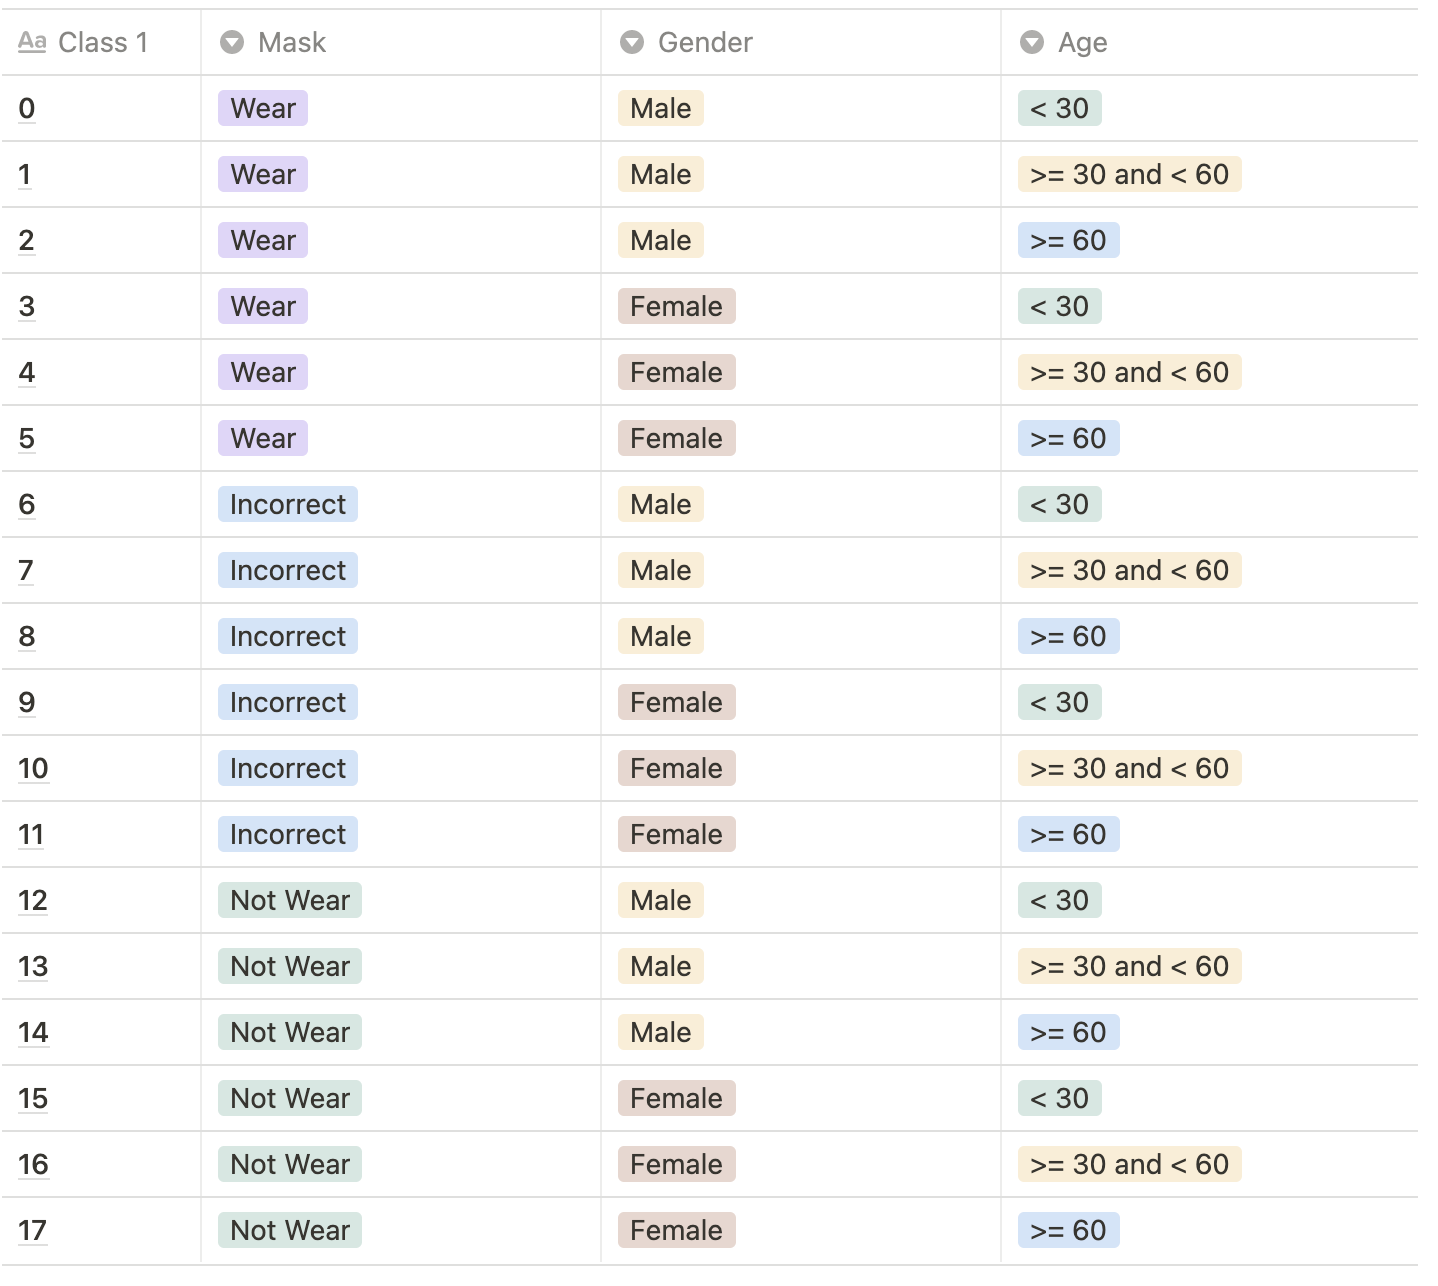